In [ ]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 15.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import  tensorflow as tf
from tensorflow import keras
from  tensorflow.keras import layers
import matplotlib. pyplot as plt
from IPython import display
from jiwer import wer

In [ ]:
data_url="https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
data_path= keras.utils.get_file("LJSpeech-1.1",data_url,untar=True)

2748572632/2748572632 ━━━━━━━━━━━━━━━━━━━━ 33s 0us/step


In [ ]:
wavs_path =data_path+"/wavs/"
metdata_path=data_path+"/metadata.csv"

In [ ]:
#Read metadata file and parse it
metadata_df=pd.read_csv(metdata_path,sep="|",header=None,quoting=3)

In [ ]:
metadata_df=metadata_df[:10]

In [ ]:
metadata_df.head(20)

,0,1,2
0,LJ001-0001,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed...","produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...
5,LJ001-0006,"And it is worth mention in passing that, as an...","And it is worth mention in passing that, as an..."
6,LJ001-0007,"the earliest book printed with movable types, ...","the earliest book printed with movable types, ..."
7,LJ001-0008,has never been surpassed.,has never been surpassed.
8,LJ001-0009,"Printing, then, for our purpose, may be consid...","Printing, then, for our purpose, may be consid..."
9,LJ001-0010,"Now, as all books not primarily intended as pi...","Now, as all books not primarily intended as pi..."


In [ ]:
metadata_df.columns=["file_name","transcription","normalized_transcription"]
metadata_df=metadata_df[["file_name","normalized_transcription"]]
metadata_df=metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df.head(20)

,file_name,normalized_transcription
0,LJ001-0008,has never been surpassed.
1,LJ001-0004,"produced the block books, which were the immed..."
2,LJ001-0003,For although the Chinese took impressions from...
3,LJ001-0006,"And it is worth mention in passing that, as an..."
4,LJ001-0005,the invention of movable metal letters in the ...
5,LJ001-0010,"Now, as all books not primarily intended as pi..."
6,LJ001-0009,"Printing, then, for our purpose, may be consid..."
7,LJ001-0007,"the earliest book printed with movable types, ..."
8,LJ001-0001,"Printing, in the only sense with which we are ..."
9,LJ001-0002,in being comparatively modern.


In [ ]:
#splitl=int(len(metadata_df)*0:30)
split=int(len(metadata_df)*0.90)
df_train=metadata_df[:split]
df_val=metadata_df[split:]
print(f"Size of the training set: {len(df_train)}")
print(f"Size of the testing set: {len(df_val)}")

Size of the training set: 9
Size of the testing set: 1


In [ ]:
#the set of characters accepted in the transcription
characters=[x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
#mapping characters to integers
char_to_num=keras.layers.StringLookup(vocabulary=characters,oov_token="")
#mapping integers back to original characters
num_to_char=keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(),oov_token="",invert=True)
print (f"the vocabulary is:{char_to_num.get_vocabulary()}"
f"(size{char_to_num.vocabulary_size()})")

the vocabulary is:['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' '](size31)


In [ ]:
# integer = scalar tensor.the window legth in samples.
frame_length=256
# an integer scalar tensor .the number of samples to step.
frame_step=160
#an integer scalar tensor . the size of the FFT to apply.
#if not provided, uses the smallest power of 2 enclosing frame _length.
fft_length=384
def encode_single_sample(wav_file,label):
  file=tf.io.read_file(wavs_path+wav_file+".wav")
  audio,_=tf.audio.decode_wav(file)
  audio=tf.squeeze(audio,axis=-1)
  audio=tf.cast(audio,tf.float32)
  spectrogram=tf.signal.stft(audio,frame_length=frame_length,frame_step=frame_step,fft_length=fft_length)
  spectrogram=tf.abs(spectrogram)
  spectrogram=tf.math.pow(spectrogram,0.5)

  means=tf.math.reduce_mean(spectrogram,1,keepdims=True)
  stddevs=tf.math.reduce_std(spectrogram,1,keepdims=True)
  spectrogram=(spectrogram-means)/(stddevs+1e-10)
  label=tf.strings.lower(label)
  label=tf.strings.unicode_split(label,input_encoding="UTF-8")
  label=char_to_num(label)
  return spectrogram,label



In [ ]:
batch_size=32
train_dataset=tf.data.Dataset.from_tensor_slices((list(df_train["file_name"]),list(df_train["normalized_transcription"])))
train_dataset=(train_dataset.map(encode_single_sample,num_parallel_calls=tf.data.AUTOTUNE)
.padded_batch(batch_size)
.prefetch(buffer_size=tf.data.AUTOTUNE))
validation_dataset=tf.data.Dataset.from_tensor_slices((list(df_val["file_name"]),list(df_val["normalized_transcription"])))
validation_dataset=(validation_dataset.map(encode_single_sample,num_parallel_calls=tf.data.AUTOTUNE)
.padded_batch(batch_size)
.prefetch(buffer_size=tf.data.AUTOTUNE))


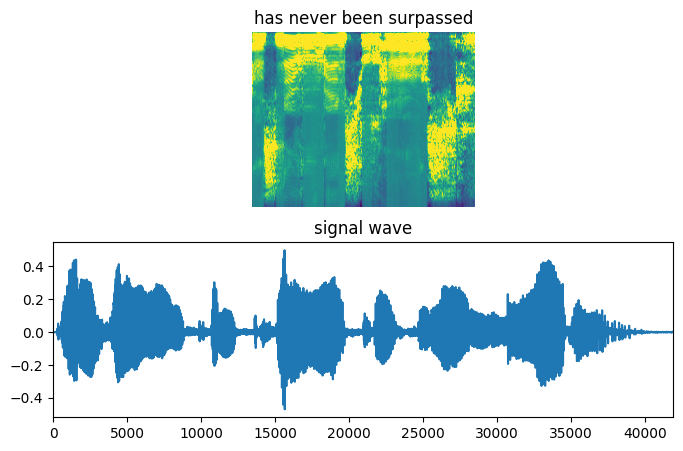

In [ ]:
fig=plt.figure(figsize=(8,5))
for batch in train_dataset.take(1):
  spectrogram=batch[0][0].numpy()
  spectrogram=np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
  label=batch[1][0]
  label=tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
  ax=plt.subplot(2,1,1)
  ax.imshow(spectrogram,vmax=1)
  ax.set_title(label)
  ax.axis("off")
  file =tf.io.read_file(wavs_path+list(df_val["file_name"])[0]+".wav")
  audio,_=tf.audio.decode_wav(file)
  audio=audio.numpy()
  ax=plt.subplot(2,1,2)
  plt.plot(audio)
  ax.set_title("signal wave")
  ax.set_xlim(0,len(audio))
  display.display(display.Audio(np.transpose (audio),rate=16000))
  plt.show()

In [ ]:
def CTCLoss(y_true,y_pred):
  batch_len=tf.cast(tf.shape(y_true)[0],dtype="int64")
  input_length=tf.cast(tf.shape(y_pred)[1],dtype="int64")
  label_length=tf.cast(tf.shape(y_true)[1],dtype="int64")
  input_length=input_length*tf.ones(shape=(batch_len,1),dtype="int64")
  label_length=label_length*tf.ones(shape=(batch_len,1),dtype="int64")
  loss=keras.backend.ctc_batch_cost(y_true,y_pred,input_length,label_length)
  return loss

In [ ]:
from tensorflow.keras import layers
from tensorflow import keras

def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    # input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)

    # The first layer of convolutions
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)

    # The second layer of convolutions
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)

    # Reshaping layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)

    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(recurrent, name=f"bidirectional_{i}", merge_mode="concat")(x)

        # Add Dropout to non-last layers
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)

    # final layer
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)

    # create the model
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")

    # Adjust optimizer and loss
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=opt, loss=CTCLoss)
    return model


# create the model
model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)

# View form summary
model.summary(line_length=110)


Model: "DeepSpeech_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                   ┃ Output Shape                        ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                             │ (None, None, 193)                   │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ expand_dim (Reshape)                           │ (None, None, 193, 1)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1 (Conv2D)                                │ (None, None, 97, 32)                │              14,432 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1_bn (BatchNormalization)                 │ (None, None, 97, 32)                │                 128 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1_relu (ReLU)                             │ (None, None, 97, 32)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2 (Conv2D)                                │ (None, None, 49, 32)                │             236,544 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2_bn (BatchNormalization)                 │ (None, None, 49, 32)                │                 128 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2_relu (ReLU)                             │ (None, None, 49, 32)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ reshape (Reshape)                              │ (None, None, 1568)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_1 (Bidirectional)                │ (None, None, 1024)                  │           6,395,904 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout (Dropout)                              │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_2 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_1 (Dropout)                            │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_3 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_2 (Dropout)                            │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_4 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_3 (Dropout)                            │ (None, None, 1024)                  │                   0 │
├───

 Total params: 25,578,880 (97.58 MB)

 Trainable params: 25,578,752 (97.58 MB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
def decode_batch_predictions(pred):
  input_len=np.ones(pred.shape[0])*pred.shape[1]
  results=keras.backend.ctc_decode(pred,input_length=input_len,greedy=True)[0][0]
  output_text=[]
  for result in results:
    result=tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
    output_text.append(result)
  return output_text

# Move the CallbackEval class definition outside the decode_batch_predictions function
class CallbackEval(keras.callbacks.Callback):  # Definition of class
    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions =model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 3):
            print(f"Target: {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)

In [ ]:
epochs=5
validation_callback=CallbackEval(validation_dataset)
history=model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Target: in being comparatively modern
Prediction: 
----------------------------------------------------------------------------------------------------
Target: in being comparatively modern
Prediction: 
----------------------------------------------------------------------------------------------------
Target: in being comparatively modern
Prediction: 
----------------------------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 122s 122s/step - loss: 1768.5857 - val_loss: 292.5295
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
-------------------

In [ ]:
prediction =[]
targets=[]
for batch in validation_dataset:
  X,y=batch
  batch_predictions=model.predict(X)
  batch_predictions=decode_batch_predictions(batch_predictions)
  prediction.extend(batch_predictions)
  for label in y:
    label=tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    targets.append(label)
wer_score=wer(targets,prediction)
print("-"*100)
for i in np.random.randint(0,len(prediction),3):
   print(f"target   :{targets[i]}")
   print(f"prediction:{prediction[i]}")
   print("-"*100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
----------------------------------------------------------------------------------------------------
target   :in being comparatively modern
prediction:
----------------------------------------------------------------------------------------------------
target   :in being comparatively modern
prediction:
----------------------------------------------------------------------------------------------------
target   :in being comparatively modern
prediction:
----------------------------------------------------------------------------------------------------
